In [91]:
#Generic
from collections import Counter
import os
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
import itertools
import datetime
from datetime import timedelta


#NLTK Stopword List
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('arabic')

#Gensim (LDA-Modelling)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.test.utils import datapath

#PDF-Reader
import pdfplumber

import pyLDAvis.gensim_models
import xml.etree.ElementTree as ETree

# plots
from bidi.algorithm import get_display
import arabic_reshaper
import matplotlib.pyplot as plt


C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# MISSING ISSUE: 85

In [5]:
#file_path = 'read_pdfs'
file_path = 'Al-Naba'

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def prepare_comp_corpus(corpus_path="Alittihad_XML_utf_8/Alittihad_utf_8.xml"):
    # read xml
    parser = ETree.XMLParser(encoding='UTF-8')
    tree = ETree.parse(corpus_path, parser=parser)
    xroot = tree.getroot()

    # extract texts
    texts = []
    for node in xroot:
        texts.append(node.find("Text").text)

    # check for text duplicates
    unique_texts_with_none = list(set(texts))
    unique_texts = []
    for ele in filter(None, unique_texts_with_none): # remove None
        unique_texts.append(ele)

    # join all texts and do naive tokenization
    words = ' '.join(unique_texts).split()

    # keep only unique words
    words = list(set(words))
    print('Unique words: ' + str(len(words)))

    # remove punct
    for pattern in [r"\W", r"\d"]:#[r"\[", r"\]", r"\(", r"\)", r"\|", r"/", r"\.", r"\:", r"\«", r"\"", r"\»", r"\'", r"\d", r"\%"]: 
        words = [re.sub(pattern, "", word) for word in words]
    return words

def get_text(file_path):
    data_list = []
    pages_list = []
    file_list = []

    for index, filename in enumerate(os.listdir(file_path)):
        if filename.endswith(".pdf"):
            with pdfplumber.open(join(file_path,filename)) as stream_pdf:
                pages_content = [i.extract_text() for i in stream_pdf.pages]
                number_pages = len(pages_content)
                data_list.extend(pages_content)
                pages_list.extend(i+1 for i in range(number_pages))
                file_list.extend([filename] * number_pages)
                
    data_df = pd.DataFrame({'content': data_list,
                            'page': pages_list,
                            'file': file_list,
                            'date': np.nan})
    return data_df

# add handselected words to the comparence dict
def load_handselected_words(path):
    with open(path, 'r', encoding='utf-8') as f:
        read_in = f.readlines()
    res = []
    for entry in read_in:
        if ',' in entry:
            res.append(entry.split(',')[0].split('\\')[0])
    return res

#283 issues, missing issue no. 85
def insert_date(df, start_date=datetime.date(2015, 10, 16)):
    res_list = []
    for row_count in range(df['date'].shape[0]):
        issue_no = int(df['file'][row_count][:-4].split('-')[-1]) # get issue no
        if issue_no == 1:
            res_list.append(start_date) # start equals date of first issue
        else:
            res_list.append(start_date + timedelta(days=(issue_no-1)*7)) # add the passed days to the start date using the issue number
    df['date'] = res_list
    return df

def preproc(data_df):
    # Convert to list and merge all issues pages
    data = []
    for issue in set(data_df['file'].values):
        data.append(' '.join(data_df['content'][data_df['file'] == issue].values))

    # Remove Emails
    data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub(r'\s+', ' ', sent) for sent in data]
    data = [re.sub(r'\n', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub(r"\'", "", sent) for sent in data]
    data = [re.sub(r"/", "", sent) for sent in data]

    # Remove Numbers
    for i in range(10):
        data = [re.sub(str(i), "", sent) for sent in data]

    # Remove Brackets
    
    reg_pat = [ r"\[", r"\]", r"\(", r"\)", r"\|", r"/", r"\.", r"\:" ]

    for pattern in reg_pat:
        data = [re.sub(pattern, "", sent) for sent in data]
    
    # data_list = []
    # for block in data:
    #     data_list.extend(block.split())

    return data

#old version
# def preproc(data_df):
#     # Convert to list
#     data = data_df['content'].values.tolist()

#     # Remove Emails
#     data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

#     # Remove new line characters
#     data = [re.sub('\s+', ' ', sent) for sent in data]
#     data = [re.sub('\n', ' ', sent) for sent in data]

#     # Remove distracting single quotes
#     data = [re.sub("\'", "", sent) for sent in data]
#     #data = [re.sub("/", "", sent) for sent in data]

#     # Remove Numbers
#     for i in range(10):
#         data = [re.sub(str(i), "", sent) for sent in data]

#     # block does not work
#     # Remove Brackets
#     ''' 
#     data = [re.sub("\[", "", sent) for sent in data]
#     data = [re.sub("\]", "", sent) for sent in data]
#     data = [re.sub("\(", "", sent) for sent in data]
#     data = [re.sub("\)", "", sent) for sent in data]
#     data = [re.sub("|", "", sent) for sent in data]
#     data = [re.sub("/", "", sent) for sent in data]
#     '''

#     return data

# unused
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# old version
# def invert_words(data_words_nostops):
#     data_words_nostops_inverted = []
#     for i in data_words_nostops:
#         temp = [j[::-1] for j in i]
#         data_words_nostops_inverted.append(temp)
#     return data_words_nostops_inverted

def invert_words(data_words_nostops):
    data_words_nostops_inverted = []
    for i in data_words_nostops:
        #print(i)
        #temp = [j[::-1] for j in i]
        #print(temp)
        #print([i for i in reversed(temp)])
        temp = [i for i in reversed(i)] # reversed
        #print(''.join(temp))
        temp = ''.join(temp)
        #print(temp)
        data_words_nostops_inverted.append(temp)
    return data_words_nostops_inverted

def grammization(data_words):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=8, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    return bigram, trigram, bigram_mod, trigram_mod

# Define functions for stopwords, bigrams, trigrams and lemmatization, rm words smaller than 3 chars
def remove_stopwords(texts):

    # def flatten(lis): # helper to flatten results
    #     return [item for sublist in lis for item in sublist if item != '']

    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word) > 2] for doc in texts]

# unused
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# unused
# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]


def gensim_prep(word_list):
    # Create Dictionary
    id2word = corpora.Dictionary(word_list)
    id2word.filter_extremes(no_below=5, keep_n=75000)
    print('Length dictionary: ' + str(len(id2word)))

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in word_list]

    return id2word, corpus

def get_lda(corpus, id2word, num_topics, n_jobs=3, passes=50, chunksize=100, save=False, model_name='myldamodel'):

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, 
                                        id2word=id2word,
                                        num_topics=num_topics,
                                        random_state=100,
                                        chunksize=chunksize,
                                        workers=n_jobs, 
                                        passes=passes,
                                        per_word_topics=True)

    try:
        if save:
            # Save model to disk.
            temp_file = datapath(model_name)
            lda_model.save(temp_file)
    except:
        print('didnt save LDA model!')
        
    return lda_model

def visu(lda_model, corpus, id2word, name):
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, name + '.html')
    return

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# preprocessing pipe 

# produce compareance list
# comparison_list = prepare_comp_corpus(corpus_path="Alittihad_XML_utf_8/Alittihad_utf_8.xml")
# handselected_words = load_handselected_words(path='most_occuring_words_modified.txt')
# comparison_list.extend(handselected_words)
# with open('comparison_list_alittihad.pkl', 'wb') as f:
#     pickle.dump(comparison_list, f, pickle.HIGHEST_PROTOCOL)

# load most occuring words
with open('most_occuring_words_modified.txt', 'r', encoding='utf-8') as f:
    most_occuring_words_mod = f.readlines()
most_occuring_words_mod = [x.strip() for x in most_occuring_words_mod] # rm newline
most_occuring_words_mod = [x.split(sep=',')[0] for x in most_occuring_words_mod if x != ''] # rm non-needed string parts and empty strings

# load compareance list
with open('comparison_list_alittihad.pkl', 'rb') as f:
    comp_list = pickle.load(f)

# load talibs approved list of real words
with open('all_words_to_be_processed_edited_by_TA.txt', 'r', encoding='utf-8') as f:
    all_words_to_be_processed = f.readlines()
    all_words_to_be_processed = [word.replace('\n','') for word in all_words_to_be_processed if (word != '\n')]

# preprocess data
data_df = get_text(file_path)
data_df = insert_date(data_df) 
data_df = data_df.dropna(subset=['content'])
data_list_inv = preproc(data_df) # words are mirrored by the pdf parser

######## data_words_inv = list(sent_to_words(data))
######## data_words = invert_words(data_words_inv)

data_words = invert_words(data_list_inv)
data_words_nostops = remove_stopwords(data_words)

# add most occuring words, check which words are in both lists
comp_list.extend(most_occuring_words_mod)
data_words_nostops_full_comp_plus_most_occ = [[word for word in doc if (word in comp_list) and (word in all_words_to_be_processed)] for doc in data_words_nostops] # format: list lists (docs) of tokens

# bigram, trigram, bigram_mod, trigram_mod = grammization(data_words_nostops)
# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

id2word, corpus = gensim_prep(data_words_nostops_full_comp_plus_most_occ)

save_dict = {'data_df': data_df, 'data_words_nostops_full_comp_plus_most_occ': data_words_nostops_full_comp_plus_most_occ, 'id2word': id2word, 'corpus': corpus }

with open('save_dict_full.pkl', 'wb') as f:
    pickle.dump(save_dict, f, pickle.HIGHEST_PROTOCOL)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# lda estimation

for n in range(8,26,3):
    print('started training model with ' + str(n) + ' topics.')
    name = str(n) + '_topics'
    lda = get_lda(corpus, id2word, n_jobs=7, num_topics=n, save=True, model_name=name)
    visu(lda, corpus, id2word, name)

# for n in [20, 30]:
#     print('started' + str(n))
#     lda = get_lda(corpus, id2word, num_topics=n)
#     name = str(n) + '_topics'
#     visu(lda, corpus, id2word, name)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


started training model with 8 topics.
started training model with 11 topics.
started training model with 14 topics.
started training model with 17 topics.
started training model with 20 topics.
started training model with 23 topics.
started training model with 26 topics.


## Word Count method

In [2]:
with open('save_dict_full.pkl', 'rb') as f:
    load_dat = pickle.load(f)
data_words_nostops_full_comp_plus_most_occ = load_dat['data_words_nostops_full_comp_plus_most_occ']

eth_groups = {
    'christians_crusaders':['نصارى', 'مسيحي', 'مسيحيون', 'مسيحيين', 'صليبيون', 'صليبيين', 'صليبي', 'مسيحي'],
    'jews':['يهود', 'يهودي', 'يهودية'],
    'western':['غرب','غربي','غربيون','غربيين'],
    'alewites':['نصيريون','نصيريين','علوي','علويون','علويين','نصيري','علوي'],
    'kurds':['كرد','أكراد','كردي','كردي'],
    'shia':['شيعة','روافض','رافضة','شيعيون','شيعيين','شيعي','رافضي'],
    'yazidis':['يزيديون','يزيديين','ايزيدي','ايزيديون','ايزيديين','يزيدي','ايزيدي']
}

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
result_dict = {}
for group_name in eth_groups.keys():                                    # iterate ethnic groups
    for word in eth_groups[group_name]:                                 # iterate words for ethnic group
        result_dict[word] = []                                          
        for doc in data_words_nostops_full_comp_plus_most_occ:          # iterate documents
            if word in doc:                                             # check if word occors in document
                indices = [i for i, x in enumerate(doc) if x == word]   # get all indices of the occurrences
                for idx_match in indices:                                # get index of matched word in document        
                    if (idx_match < 21) and (len(doc) - idx_match < 20):    # index too close to document start and too close to end 
                        for word_left in range(idx_match):                  # add words on the left
                            result_dict[word].append(doc[word_left]) 
                        for word_right in range(len(doc) - idx_match, len(doc)):  # add words on the right
                            result_dict[word].append(doc[word_right])
                    elif (idx_match < 21) and (len(doc) - idx_match >= 20): # index too close to document start but centered on the right
                        for word_left in range(idx_match):                  
                            result_dict[word].append(doc[word_left])
                        for word_right in range(idx_match, idx_match + 20):  
                            result_dict[word].append(doc[word_right])
                    elif (idx_match >= 21) and (len(doc) - idx_match < 20): # index too close to document end but centered on the left
                        for word_left in range(idx_match-20, idx_match):                  
                            result_dict[word].append(doc[word_left])
                        for word_right in range(len(doc) - idx_match, len(doc)):
                            result_dict[word].append(doc[word_right])
                    else:                                                   # index sufficiently in document center
                        for word_left in range(idx_match-20, idx_match):             
                            result_dict[word].append(doc[word_left])
                        for word_right in range(idx_match, idx_match + 20):  
                            result_dict[word].append(doc[word_right])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
max_words = 30
count_dfs_lists = []
for key in result_dict.keys():
    df = pd.DataFrame.from_records(Counter(result_dict[key]).most_common(max_words), columns=[key,'count'])
    if df.shape[0] != 0 and df.shape != 0:
        count_dfs_lists.append(df)
count_dfs_lists[0]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,نصارى,count
0,نصارى,104
1,النصارى,57
2,جمادى,57
3,ربيع,42
4,برنو,37
5,للنصارى,29
6,بتوفيق,29
7,بيني,28
8,خمسة,23
9,لهالك,23


In [5]:
len(count_dfs_lists)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


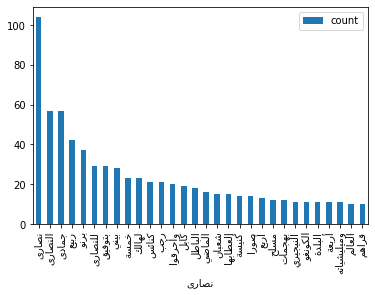

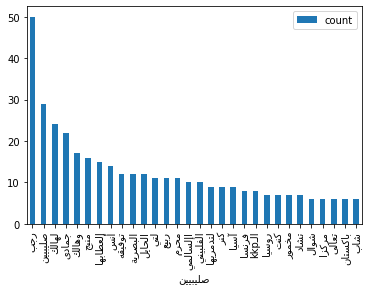

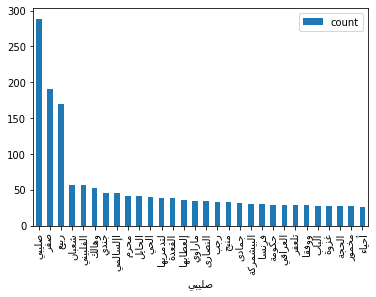

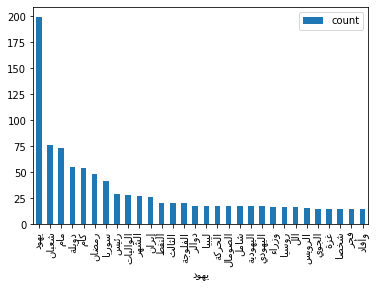

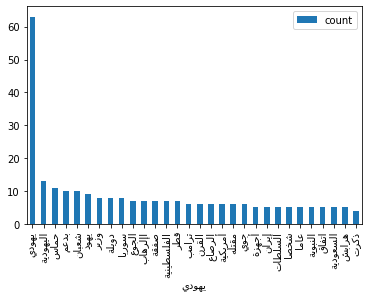

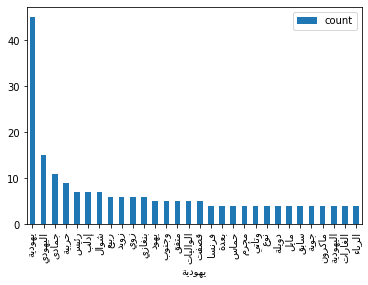

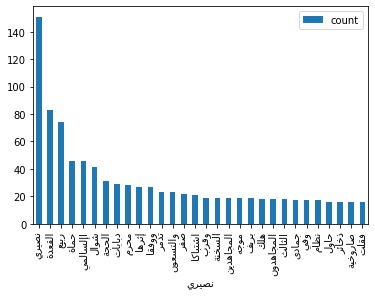

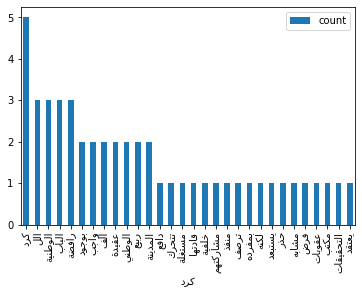

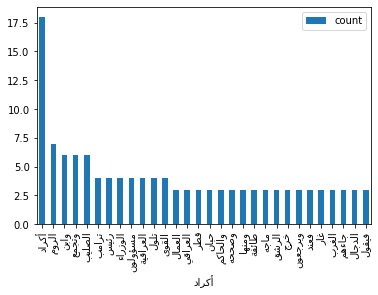

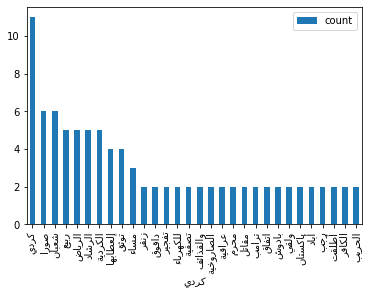

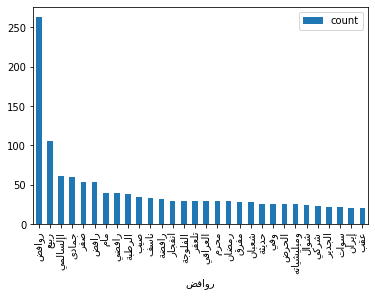

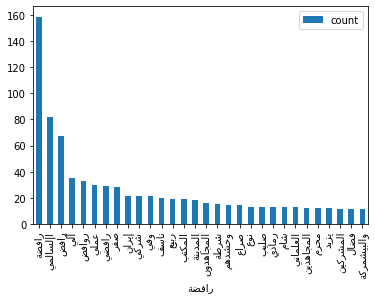

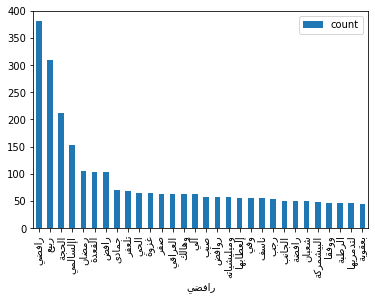

In [6]:

# We prepare the plot  

save_path = r'./ethnic_group_visualization/'
for i in range(len(count_dfs_lists)):
    # We change the fontsize of minor ticks label 
    #fig, axis = plt.subplots()
    #axis.tick_params(axis='both', which='major', labelsize=10)
    #axis.tick_params(axis='both', which='minor', labelsize=8)
    reverse_via_bidi_alg = []                                       # reverse arabic words: https://stackoverflow.com/questions/54064646/arabic-letters-arent-showing-correctly-in-the-plot
    for word in count_dfs_lists[i][count_dfs_lists[i].columns[0]]:
        reverse_via_bidi_alg.append(get_display(arabic_reshaper.reshape(word)))
    count_dfs_lists[i].rename(columns={count_dfs_lists[i].columns[0]:get_display(arabic_reshaper.reshape(count_dfs_lists[i].columns[0]))}, inplace=True) # reverse/ reshape column name
    count_dfs_lists[i][count_dfs_lists[i].columns[0]] = reverse_via_bidi_alg
    count_dfs_lists[i].plot.bar(x=count_dfs_lists[i].columns[0], y=count_dfs_lists[i].columns[1])
    plt.savefig(save_path+arabic_reshaper.reshape(count_dfs_lists[i].columns[0]))

In [7]:
# save data, restricted to 150 words

max_words = 150

tfile = open('ethnic_group_most_occuring_words_count.txt', 'w', encoding='utf-8')
tfile.close()
for key in result_dict.keys():
    df = pd.DataFrame.from_records(Counter(result_dict[key]).most_common(max_words), columns=[key,'count'])
    tfile = open('ethnic_group_most_occuring_words_count.txt', 'a', encoding='utf-8')
    tfile.write('###################################################################################################################################')
    tfile.write('\n')
    tfile.write(df.to_csv(index=False))
    tfile.close()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Analyze the outgroups over time:

In [6]:
for df in count_dfs_lists:
    print(df.keys()[0])

نصارى
صليبيين
صليبي
يهود
يهودي
يهودية
نصيري
كرد
أكراد
كردي
روافض
رافضة
رافضي


C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# get a list of all the filenames from 'data_df' IN ORDER to concatenate the cleaned tokens
ordered_filenames = list(dict.fromkeys(load_dat['data_df']['file']))
len(ordered_filenames)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


282

In [8]:
# add the tokens from 'data_words_nostops_full_comp_plus_most_occ' to each row in 'data_df', 
# since an issue has as any rows as pages, we append it len(page) times
list_of_corresponding_tokens_for_each_row_of_data_df = []
for filename, tokens in zip(ordered_filenames, data_words_nostops_full_comp_plus_most_occ): # iterate filenames and the corresponding tokens in two lists
    for row in load_dat['data_df']['file']:                                                 # iterate through the rows of the target df
        if filename == str(row):                                                            # append the tokens as often as an issue has pages
            list_of_corresponding_tokens_for_each_row_of_data_df.append(tokens)
load_dat['data_df']['data_words_nostops_full_comp_plus_most_occ'] = list_of_corresponding_tokens_for_each_row_of_data_df
# change to 'date' column to datetime:
load_dat['data_df']['date'] = pd.to_datetime(load_dat['data_df']['date'])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# Sort and merge issue tokens by month
months = range(1, 13)
years = range(2015, 2022)
dict_of_tokens_by_months = {}

import itertools

for year in years:
    for month in months:
        # get all issues for each month, drop all unwanted rows with duplicate 'data_words_nostops_full_comp_plus_most_occ' / 'date' (if one is a duplicate, the other is, too)
        df_by_month_unique_date = load_dat['data_df'][(load_dat['data_df']['date'].dt.month == month) & (load_dat['data_df']['date'].dt.year == year)].copy().drop_duplicates(subset=['date'])
        #print(df_by_month_unique_date)
        if not df_by_month_unique_date.empty: # check if there are any issues in respective month
            # prefix zero for month
            if len(str(month)) == 1:
                month = '0' + str(month)
            # flatten all lists and merge them to one.
            dict_of_tokens_by_months[str(year) + '-' + str(month)] = list(itertools.chain(*df_by_month_unique_date['data_words_nostops_full_comp_plus_most_occ'].tolist()))
dict_of_tokens_by_months.keys()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03'])

In [75]:
dict_of_tokens_by_months['2016-10']

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['باقية',
 'السجون',
 'انتهت',
 'نقول',
 'أرحم',
 'بهدم',
 'أسوار',
 'قتالنا',
 'حذو',
 'إخوانكم',
 'عزم',
 'عليكم',
 'حفظه',
 'تبارك',
 'اللهم',
 'أجناد',
 'الواليات',
 'نصب',
 'فتحا',
 'عظيما',
 'يعز',
 'وأمر',
 'واجعلوا',
 'تقوى',
 'إياها',
 'شأنه',
 'عاله',
 'اللهم',
 'القادم',
 'أدهى',
 'العيل',
 'نعمة',
 'عظيمة',
 'يعلم',
 'الساعة',
 'وإننا',
 'اللهم',
 'احفظ',
 'عبادك',
 'ماض',
 'قيام',
 'عادته',
 'أقوام',
 'فواصلوا',
 'بتقوى',
 'الس',
 'والعلن',
 'أشقياء',
 'تحكيم',
 'غايته',
 'وأفراد',
 'منقطع',
 'خائفون',
 'أذلة',
 'وتصفية',
 'رؤوس',
 'آثروا',
 'الخزي',
 'والعار',
 'دائم',
 'عقر',
 'وأنتم',
 'خير',
 'كثير',
 'منقطع',
 'دركم',
 'فلقد',
 'صدور',
 'أحزاب',
 'والردة',
 'آثروا',
 'الخزي',
 'والعار',
 'دائم',
 'رجال',
 'عشاق',
 'النزال',
 'قطف',
 'الثمار',
 'بدقة',
 'فيكم',
 'أحزاب',
 'والردة',
 'الثمار',
 'بدقة',
 'آساد',
 'الصومال',
 'قدر',
 'قطف',
 'نقول',
 'إبراهيم',
 'الهاشمي',
 'القريش',
 'حفظه',
 'جهادنا',
 'انتهى',
 'القرشي',
 'حفظه',
 'تعالى',
 'بأنفسهم',
 'وخليفة',
 'توحي

In [76]:
# get the counts of each of the outgroups mentions per months
outgroups_helper_dict = {}
for df in count_dfs_lists:
    current_outgroup = df.keys()[0] # df.keys()[0]: outgroup with min one mention in corpus
    current_outgroup_count_dict = {}
    for month in dict_of_tokens_by_months.keys():
        current_outgroup_count_dict[month] = dict_of_tokens_by_months[month].count(current_outgroup)
    outgroups_helper_dict[current_outgroup] = current_outgroup_count_dict
outgroups_helper_dict.keys()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['نصارى', 'صليبيين', 'صليبي', 'يهود', 'يهودي', 'يهودية', 'نصيري', 'كرد', 'أكراد', 'كردي', 'روافض', 'رافضة', 'رافضي'])

In [78]:
outgroups_helper_dict['رافضي'].keys()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03'])

In [79]:
outgroups_helper_dict['رافضي']['2015-10']

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


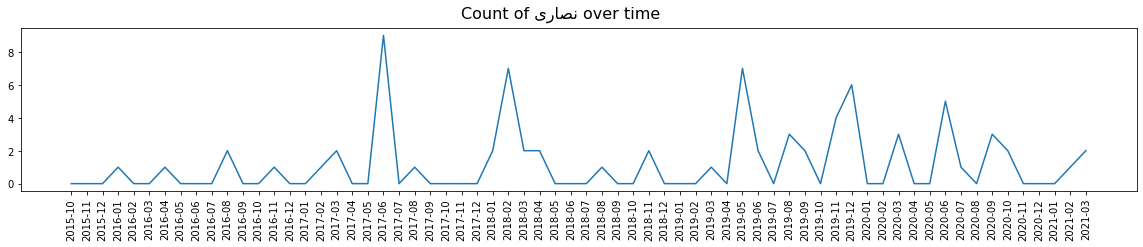

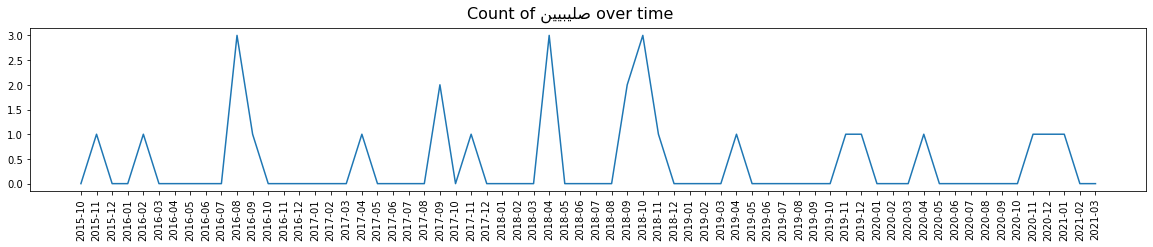

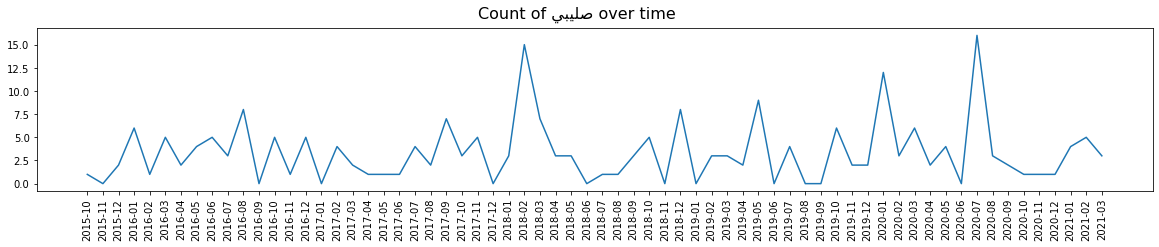

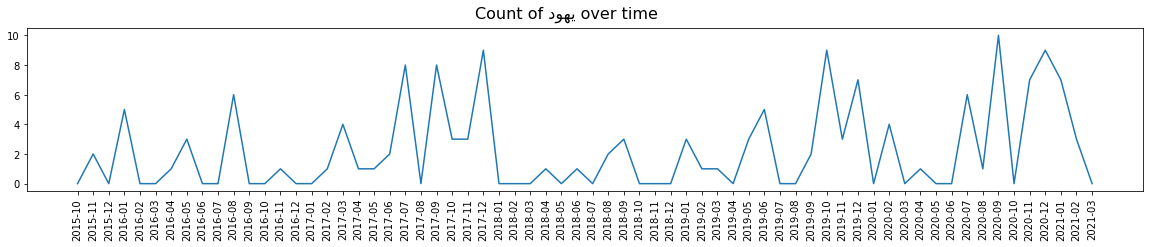

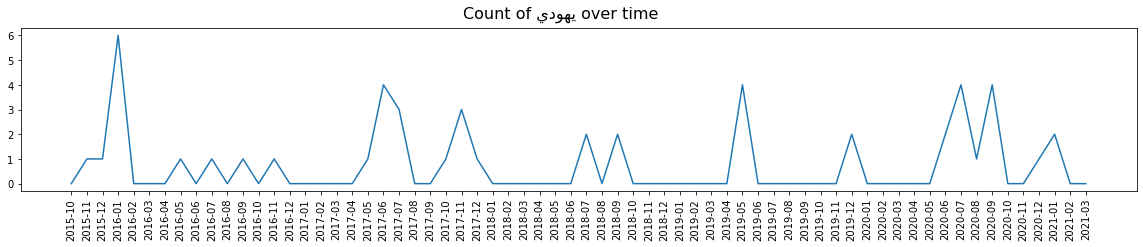

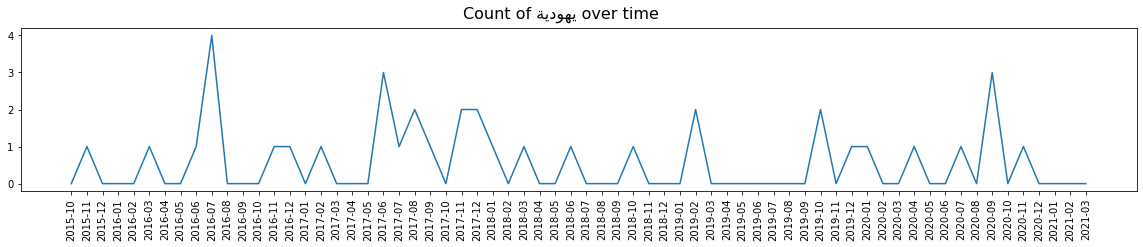

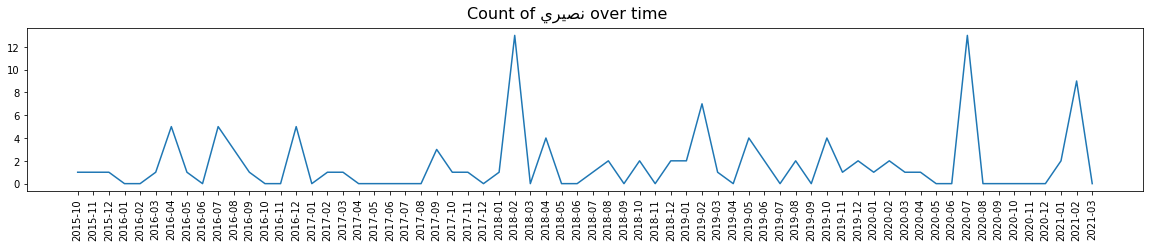

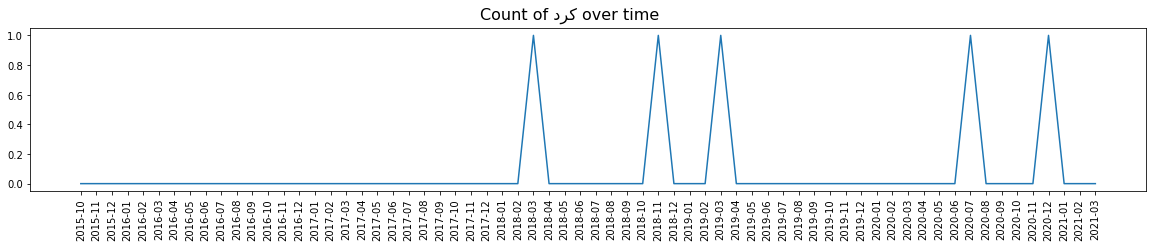

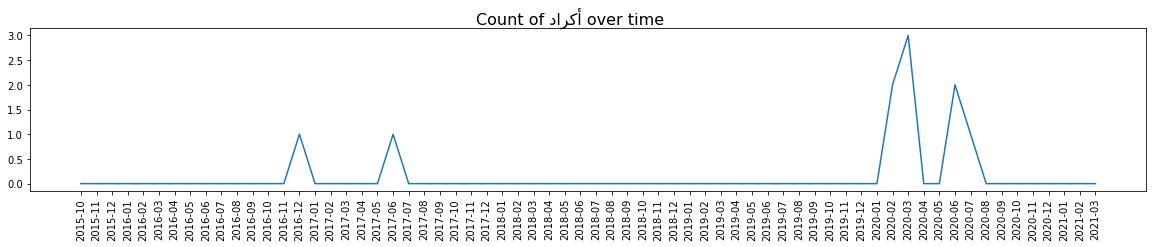

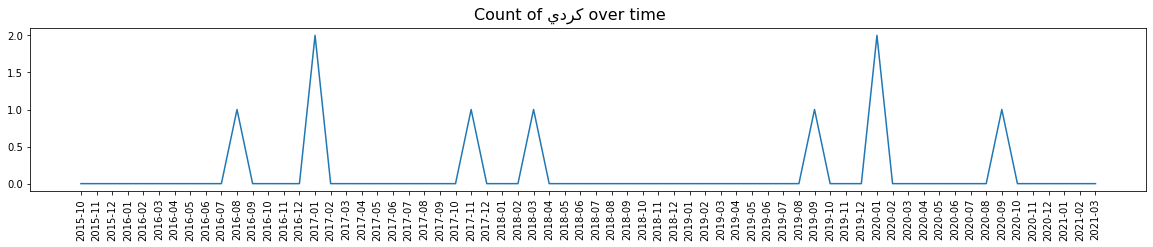

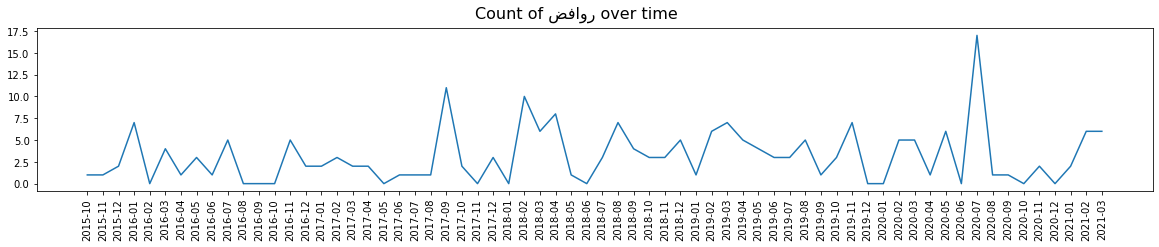

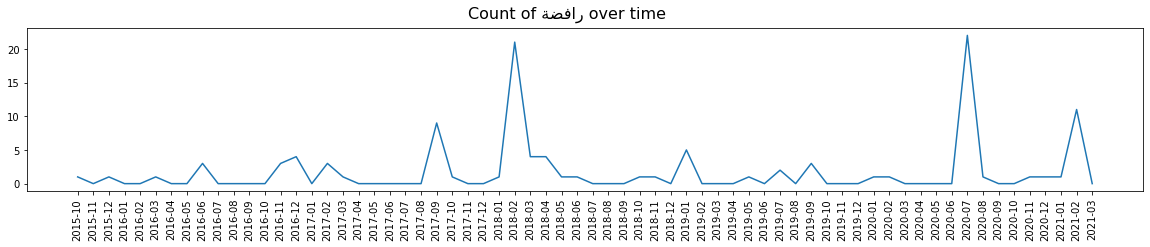

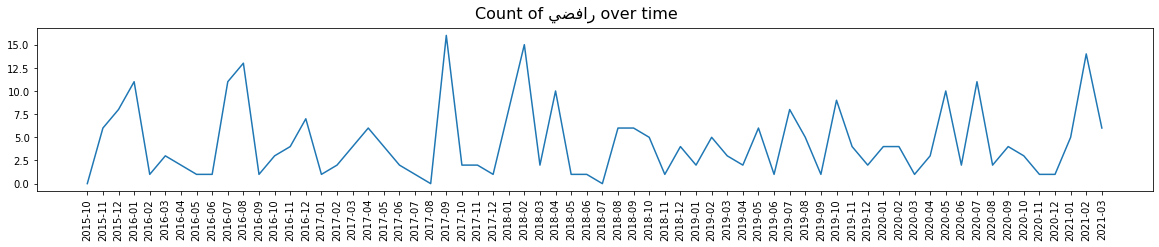

In [99]:
save_path_2 = r'./ethnic_group_visualization/count_over_time/'
for outgroup in outgroups_helper_dict.keys():
    plt.rcParams["figure.figsize"] = (20,3)
    plt.suptitle('Count of ' + get_display(arabic_reshaper.reshape(outgroup)) + ' over time', fontsize=16)
    plt.plot(outgroups_helper_dict[outgroup].keys(), outgroups_helper_dict[outgroup].values())
    plt.xticks(rotation=90)
    plt.savefig(save_path_2+arabic_reshaper.reshape(outgroup)+'_count_over_time.png')
    plt.show()